## **Interpolation between flow parameters**

This algorithm is capable of predicting expanding fluid dynamics databases through the combination of Higher-order singular value decomposition (HOSVD) and Process Gaussian Regression or Kriging interpolation. HOSVD is an extension of SVD for multi-dimensional tensors, the main advantage of the usage of this modal decomposition method relies on the capacity to extract patterns of the flow taking into account the strong relationships between dimensions and its compression and denoising attributes.


---


This code has been developed using pyKrige library with modal decomposition.

---





Install the tensorflow 2.10.0 version. Current versions are also supported.

---



In [ ]:
!pip install tensorflow==2.10.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.10.0




---
Install required packages.


---



In [ ]:

!pip install mat73
!pip install streamlit
!pip install keras-tuner
!pip install hdf5storage
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 10.8 MB/s eta 0:00:00


---

Check the python and tensorflow versions.


---



In [ ]:
!python --version
import tensorflow as tf
print(tf.__version__)

Python 3.11.11
2.18.0


---
Set the drive account to import the database.

---

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


---

Import the required functions from other .py files.

---


In [ ]:
import sys
import os

lib_folder = '/content/drive/MyDrive/Colab_Notebooks/datasets'
sys.path.append(lib_folder)

---

Import the required layers, optimizers, etc. from Keras.

---



In [ ]:
import hosvd
import tfhosvd
import numpy as np
import time
import scipy.io
import mat73
import matplotlib.pyplot as plt
import tensorflow as tf
from pykrige.ok import OrdinaryKriging

# Definition of functions

In [ ]:

def perform_hosvd(tensor, tolerance):

    SNAP = tensor.shape[-1]

    TimePos = tensor.ndim-1

    Tensor0 = tensor.copy()
    shapeTens = list(np.shape(tensor))
    shapeTens[-1] = SNAP
    Tensor = np.zeros(shapeTens)

    Tensor[..., :] = Tensor0[..., 0:SNAP]

    nn0 = np.array(Tensor.shape)
    nn = np.array(nn0)
    nn[1:np.size(nn)] = 0

    return hosvd.HOSVD(Tensor, tolerance, nn, nn0, TimePos)

QR normalization (This should be performed to guarantee the orthonormalization.)

In [ ]:
def re_orthonormalize(tensor):
    Q,R = np.linalg.qr(tensor)
    return np.matmul(Q,R)


Kriging function.

In [ ]:
def perform_kriging_interpolation(m_matrix, re_labels, desired_re):
    """
    Perform kriging for each column in m_matrix to get interpolated values for a specific Reynolds number or Angles of Attack.

    Arguments:
    - m_matrix: The matrix containing data to be interpolated (e.g., POD modes).
    - re_labels: List of Reynolds numbers/Angles of attack corresponding to rows of m_matrix.
    - desired_re: The Reynolds number at which interpolation is desired.

    Returns:
    - interpolated_row: A 1D array containing interpolated values for the specified Reynolds number.
    """
    interpolated_row = np.zeros((m_matrix.shape[1],))  # Number of modes

    for j in range(m_matrix.shape[1]):  # Iterate over columns (modes)
        column_data = m_matrix[:, j]  # Extract column data
        Re_flat = re_labels
        Mode_flat = np.full_like(Re_flat, j)  # Create mode labels

        # Create and fit the Kriging model
        kriging_model = OrdinaryKriging(Re_flat, Mode_flat, column_data, variogram_model='exponential')

        # Perform interpolation
        interpolated_value, _ = kriging_model.execute('points', np.array([desired_re]), np.array([j]))
        interpolated_row[j] = interpolated_value[0]  # Store the interpolated value

    print(f'Interpolated row for Reynolds number {desired_re}: {interpolated_row}')
    return interpolated_row

## **Main process.**

Data loading.

Upload the tensor that is goingo to be expanded in means of Reynolds or Angle of Attack. The user can select a study region on the tensor, in order to reduce the training time and avoid the use of irrelevant information during training.

In [ ]:
tensor = np.load('/content/drive/MyDrive/Colab_Notebooks/datasets/tensor_7_128_250.npy')
print(tensor.shape)
#if you are working in local use the code commented below
#tensor = np.load('tensor_7_128_250.npy')

(4, 7, 128, 128, 250)


The tensor must have a shape of :  (n_comp, n_Re or AoA, n_X, n_Y, n_t)

In [ ]:
varepsilon1 = 1e-3 #varepsilon refers to the tolerance given to the decomposition (e.g to be 1e-3)

print('\nPerforming HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = perform_hosvd(tensor, varepsilon1)


Performing HOSVD. Please wait...



2025-01-30 15:45:24.834 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 15:45:25.784 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-01-30 15:45:25.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 15:45:25.786 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 15:45:25.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 15:45:25.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 15:45:25.788 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 15:45:25.791 Thread 'MainThread': mi

In [ ]:
U_copy = U.copy() #Make a copy of the mode matrices tensor in order to not change the original one.

Run the code below for the interpolation between Angles of Attack.

In [ ]:
feature_matrix = U_copy[0,1]
print(feature_matrix.shape)
#definition of labels for interpolation

feature_dim = feature_matrix.shape[0]

feature_labels = [0, 0.5, 1.0,1.5, 2.0, 2.5, 3.0] #labels for each AoA or Reynolds number.

desired_feature = float(input('write the desidered feature'))

idx_below = np.searchsorted(feature_labels, desired_feature, side='right') - 1

feature_interpolated = perform_kriging_interpolation(feature_matrix, feature_labels, desired_feature)

upper_part = feature_matrix[:idx_below+1]
lower_part = feature_matrix[idx_below+1:]

feature_matrix = np.vstack((upper_part, feature_interpolated, lower_part))

U_copy[0,1] = feature_matrix

new_tensor = hosvd.tprod(S, U_copy)

(7, 7)
write the desidered feature1.25
Interpolated row for Reynolds number 1.25: [ 3.78175561e-01 -3.66820347e-01  6.89863733e-02 -3.68454788e-01
  4.04735627e-05 -1.72624795e-05  1.91998448e-05]


Plot the interpolation results

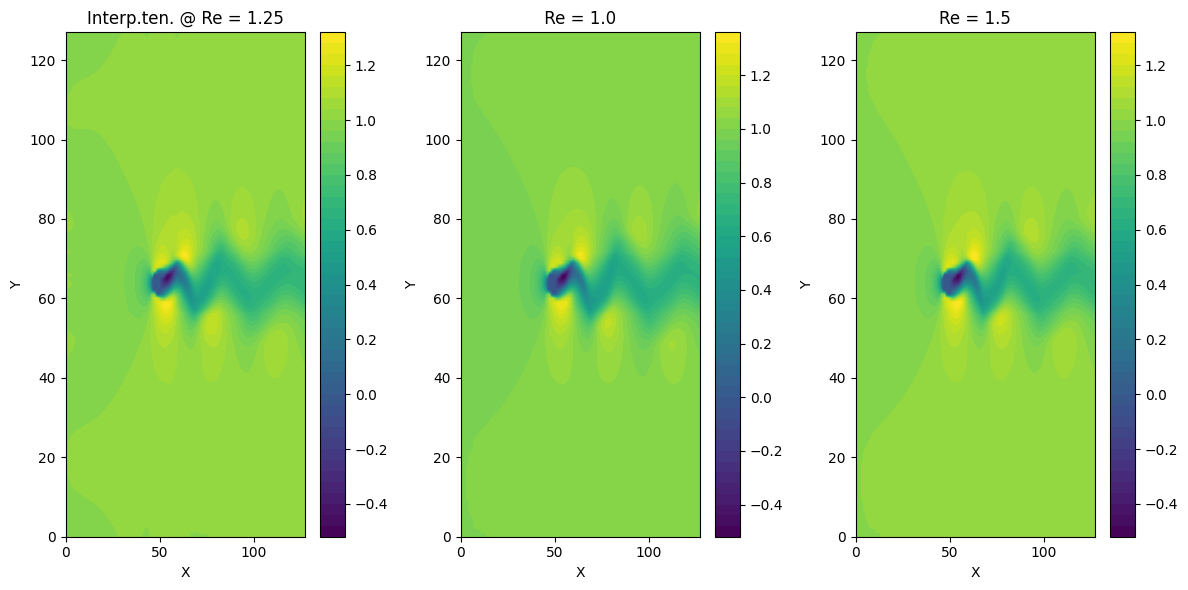

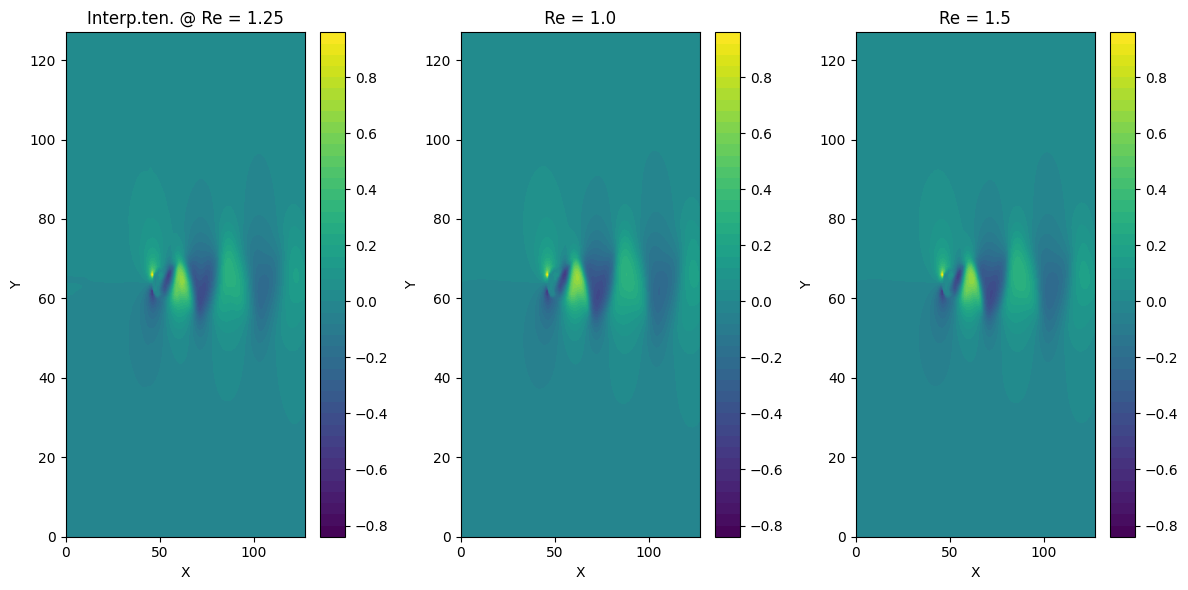

In [ ]:
i = idx_below +1

# Contour plot for the streamwise velocity component

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

contour1 = ax[0].contourf(new_tensor[0, i, :, :, 0], levels = 50)
ax[0].set_title(f'Interp.ten. @ Re = {desired_feature}')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
plt.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(tensor[0, i, :, :, 0], levels =50)
ax[1].set_title(f' Re = {feature_labels[idx_below]} ')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
plt.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(tensor[0, i-1, :, :, 0], levels =50)
ax[2].set_title(f'Re = {feature_labels[idx_below+1]}')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
plt.colorbar(contour3, ax=ax[2])


plt.tight_layout()
plt.show()

# Contour plot for the normal velocity component

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

contour1 = ax[0].contourf(new_tensor[1, i, :, :, 0], levels = 50)
ax[0].set_title(f'Interp.ten. @ Re = {desired_feature}')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
plt.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(tensor[1, i, :, :, 0], levels =50)
ax[1].set_title(f' Re = {feature_labels[idx_below]} ')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
plt.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(tensor[1, i-1, :, :, 0], levels =50)
ax[2].set_title(f'Re = {feature_labels[idx_below+1]}')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
plt.colorbar(contour3, ax=ax[2])


plt.tight_layout()
plt.show()

Run the code below for Reynolds number interpolation

In [ ]:
tensor = np.load('/content/drive/MyDrive/Colab_Notebooks/datasets/tensor_8_128_250.npy')
#if you are working in local use the code commented below
#tensor = np.load('tensor_7_128_250.npy')
print(tensor.shape)

(4, 8, 128, 128, 250)


In [ ]:
varepsilon1 = 1e-3

print('\nPerforming HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = perform_hosvd(tensor, varepsilon1)


Performing HOSVD. Please wait...



2025-01-30 16:03:42.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.428 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 16:03:42.429 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
U_copy = U.copy() #Make a copy of the mode matrices tensor in order to not change the original one.

In [ ]:
feature_matrix = U_copy[0,1]
print(feature_matrix.shape)
#definition of labels for interpolation

feature_dim = feature_matrix.shape[0]

feature_labels = [200, 220, 240, 260, 280, 300,320, 340 ]

desired_feature = float(input('write the desidered feature'))

idx_below = np.searchsorted(feature_labels, desired_feature, side='right') - 1

feature_interpolated = perform_kriging_interpolation(feature_matrix, feature_labels, desired_feature)

upper_part = feature_matrix[:idx_below+1]
lower_part = feature_matrix[idx_below+1:]

feature_matrix = np.vstack((upper_part, feature_interpolated, lower_part))

U_copy[0,1] = feature_matrix

new_tensor = hosvd.tprod(S, U_copy)

(8, 8)
write the desidered feature210
Interpolated row for Reynolds number 210.0: [ 3.53944590e-01 -1.68089407e-01 -1.81755685e-01 -3.63633194e-01
 -6.14211895e-05  6.12246804e-05 -9.96747985e-06  1.48342370e-05]


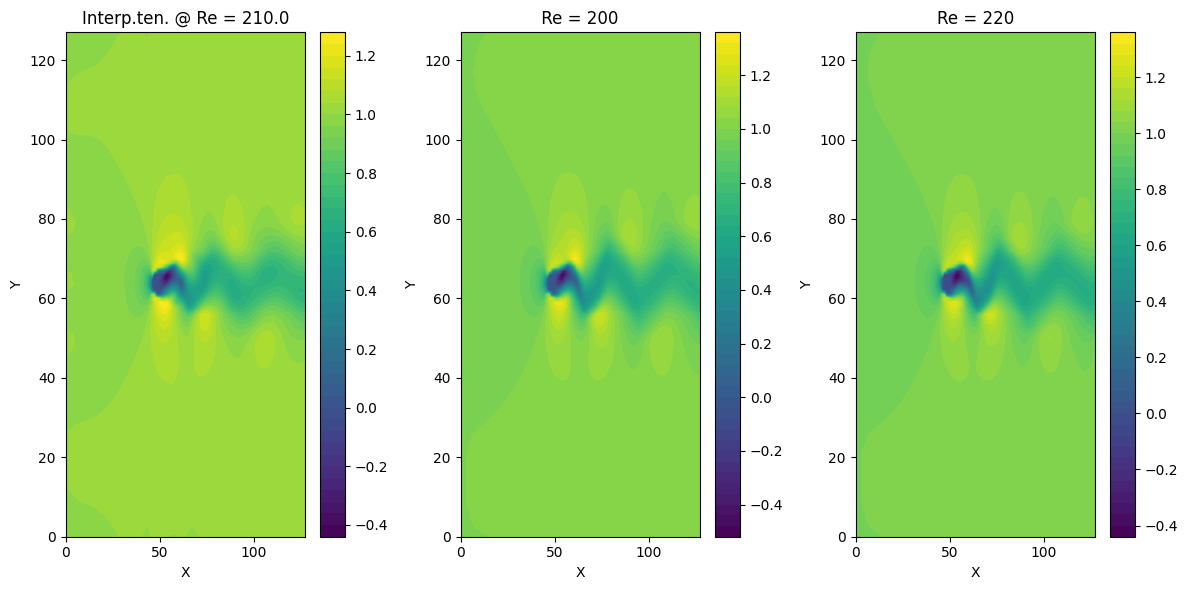

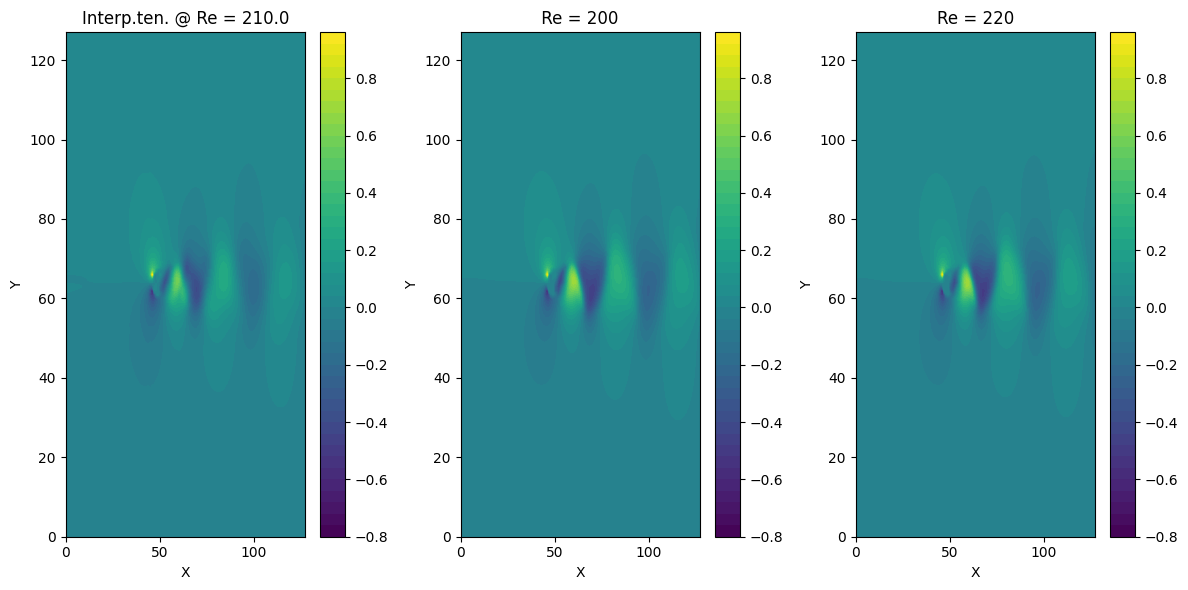

In [ ]:
i = idx_below +1

# Contour plot for the streamwise velocity component

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

contour1 = ax[0].contourf(new_tensor[0, i, :, :, 0], levels = 50)
ax[0].set_title(f'Interp.ten. @ Re = {desired_feature}')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
plt.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(tensor[0, i, :, :, 0], levels =50)
ax[1].set_title(f' Re = {feature_labels[idx_below]} ')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
plt.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(tensor[0, i-1, :, :, 0], levels =50)
ax[2].set_title(f'Re = {feature_labels[idx_below+1]}')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
plt.colorbar(contour3, ax=ax[2])


plt.tight_layout()
plt.show()

# Contour plot for the normal velocity component

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

contour1 = ax[0].contourf(new_tensor[1, i, :, :, 0], levels = 50)
ax[0].set_title(f'Interp.ten. @ Re = {desired_feature}')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
plt.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(tensor[1, i, :, :, 0], levels =50)
ax[1].set_title(f' Re = {feature_labels[idx_below]} ')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
plt.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(tensor[1, i-1, :, :, 0], levels =50)
ax[2].set_title(f'Re = {feature_labels[idx_below+1]}')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
plt.colorbar(contour3, ax=ax[2])


plt.tight_layout()
plt.show()